Maybe we define new structure which captures the input parameters specific to each problem in one place (`scale_factor`).
We need to define a range on `d` that is also function dependent (that we could adjust by hand). 

We need to generate three graphs: 
- Histogram of Number of `loc_min` points were found, (so outputs of the Optim routine) and what percentage of them is within a small distance of a critical point of the approximant. As a function of the degree `d` of the approximant.


In [73]:
using Pkg
using Revise 
Pkg.activate("../../.")
using Globtim
using DynamicPolynomials, DataFrames
using ProgressLogging
using Optim
using CairoMakie
CairoMakie.activate!

  Activating project at `~/globtim`


activate! (generic function with 1 method)

Can a function export "Optional attributes" like just some constants or its optimal domain of definition? --> works. 

In [2]:
params = load_function_params("HolderTable")
TR = test_input(HolderTable;
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=params.tolerance)

@polyvar(x[1:TR.dim]); # Define polynomial ring 

In [8]:
d_min, d_max = 4, 30
TD = 0.5

0.5

In [4]:
results = analyze_degrees(TR, x, d_min, d_max, step=1, tol_dist=TD)

current L2-norm: 4.299336658869571
Dimension m of the vector space: 15

=== Starting MSolve Parser (dimension: 2) ===
Processed 9 points (0.002s)
Processing point 1 of 9
Optimization has converged within bounds: ✓
Processing point 2 of 9
Optimization has converged within bounds: ✓
Processing point 3 of 9
Optimization has converged within bounds: ✓
Processing point 4 of 9
Optimization has converged within bounds: ✓
Processing point 5 of 9
Optimization has converged within bounds: ✓
Processing point 6 of 9
Optimization has converged within bounds: ✓
Processing point 7 of 9
Optimization has converged within bounds: ✓
Processing point 8 of 9
Optimization has converged within bounds: ✓
Processing point 9 of 9
Optimization has converged within bounds: ✓
current L2-norm: 4.29933665886957
Dimension m of the vector space: 21

=== Starting MSolve Parser (dimension: 2) ===
Processed 14 points (0.0s)
Processing point 1 of 9
Optimization has converged within bounds: ✓
Processing point 2 of 9
Optimi

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155



Dimension m of the vector space: 55

=== Starting MSolve Parser (dimension: 2) ===
Processed 52 points (0.0s)
Processing point 1 of 37
Optimization has converged within bounds: ✓
Processing point 2 of 37
Optimization has converged within bounds: ✓
Processing point 3 of 37
Optimization has converged within bounds: ✓
Processing point 4 of 37
Optimization has converged within bounds: ✓
Processing point 5 of 37
Optimization status: ✗ (did not converge)
Processing point 6 of 37
Optimization status: ✗ (did not converge)
Processing point 7 of 37
Optimization has converged within bounds: ✓
Processing point 8 of 37
Optimization has converged within bounds: ✓
Processing point 9 of 37
Optimization has converged within bounds: ✓
Processing point 10 of 37
Optimization has converged within bounds: ✓
Processing point 11 of 37
Optimization status: ✗ (outside bounds)
Processing point 12 of 37
Optimization status: ✗ (outside bounds)
Processing point 13 of 37
Optimization has converged within bounds: ✓


┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155



Dimension m of the vector space: 66

=== Starting MSolve Parser (dimension: 2) ===
Processed 81 points (0.0s)
Processing point 1 of 81
Optimization has converged within bounds: ✓
Processing point 2 of 81
Optimization has converged within bounds: ✓
Processing point 3 of 81
Optimization status: ✗ (did not converge)
Processing point 4 of 81
Optimization status: ✗ (did not converge)
Processing point 5 of 81
Optimization status: ✗ (did not converge)
Processing point 6 of 81
Optimization status: ✗ (did not converge)
Processing point 7 of 81
Optimization has converged within bounds: ✓
Processing point 8 of 81
Optimization has converged within bounds: ✓
Processing point 9 of 81
Optimization has converged within bounds: ✓
Processing point 10 of 81
Optimization has converged within bounds: ✓
Processing point 11 of 81
Optimization has converged within bounds: ✓
Processing point 12 of 81
Optimization has converged within bounds: ✓
Processing point 13 of 81
Optimization has converged within bounds

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 78

=== Starting MSolve Parser (dimension: 2) ===
Processed 84 points (0.001s)
Processing point 1 of 81
Optimization has converged within bounds: ✓
Processing point 2 of 81
Optimization has converged within bounds: ✓
Processing point 3 of 81
Optimization status: ✗ (did not converge)
Processing point 4 of 81
Optimization status: ✗ (did not converge)
Processing point 5 of 81
Optimization status: ✗ (did not converge)
Processing point 6 of 81
Optimization status: ✗ (did not converge)
Processing point 7 of 81
Optimization has converged within bounds: ✓
Processing point 8 of 81
Optimization has converged within bounds: ✓
Processing point 9 of 81
Optimization has converged within bounds: ✓
Processing point 10 of 81
Optimization has converged within bounds: ✓
Processing point 11 of 81
Optimization has converged within bounds: ✓
Processing point 12 of 81
Optimization has converged within bounds: ✓
Processing point 13 of 81
Optimization has converged within boun

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155


Optimization has converged within bounds: ✓
Processing point 60 of 81
Optimization has converged within bounds: ✓
Processing point 61 of 81
Optimization has converged within bounds: ✓
Processing point 62 of 81
Optimization has converged within bounds: ✓
Processing point 63 of 81
Optimization has converged within bounds: ✓
Processing point 64 of 81
Optimization has converged within bounds: ✓
Processing point 65 of 81
Optimization has converged within bounds: ✓
Processing point 66 of 81
Optimization status: ✗ (did not converge)
Processing point 67 of 81
Optimization status: ✗ (did not converge)
Processing point 68 of 81
Optimization has converged within bounds: ✓
Processing point 69 of 81
Optimization has converged within bounds: ✓
Processing point 70 of 81
Optimization has converged within bounds: ✓
Processing point 71 of 81
Optimization has converged within bounds: ✓
Processing point 72 of 81
Optimization has converged within bounds: ✓
Processing point 73 of 81
Optimization has converg

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 105

=== Starting MSolve Parser (dimension: 2) ===
Processed 98 points (0.001s)
Processing point 1 of 93
Optimization has converged within bounds: ✓
Processing point 2 of 93
Optimization has converged within bounds: ✓
Processing point 3 of 93
Optimization has converged within bounds: ✓
Processing point 4 of 93
Optimization has converged within bounds: ✓
Processing point 5 of 93
Optimization has converged within bounds: ✓
Processing point 6 of 93
Optimization has converged within bounds: ✓
Processing point 7 of 93
Optimization has converged within bounds: ✓
Processing point 8 of 93
Optimization status: ✗ (outside bounds)
Processing point 9 of 93
Optimization status: ✗ (outside bounds)
Processing point 10 of 93
Optimization has converged within bounds: ✓
Processing point 11 of 93
Optimization status: ✗ (outside bounds)
Processing point 12 of 93
Optimization status: ✗ (outside bounds)
Processing point 13 of 93
Optimization status: ✗ (did not converge)
Pro

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155



Dimension m of the vector space: 120

=== Starting MSolve Parser (dimension: 2) ===
Processed 153 points (0.001s)
Processing point 1 of 133
Optimization has converged within bounds: ✓
Processing point 2 of 133
Optimization has converged within bounds: ✓
Processing point 3 of 133
Optimization has converged within bounds: ✓
Processing point 4 of 133
Optimization has converged within bounds: ✓
Processing point 5 of 133
Optimization has converged within bounds: ✓
Processing point 6 of 133
Optimization has converged within bounds: ✓
Processing point 7 of 133
Optimization has converged within bounds: ✓
Processing point 8 of 133
Optimization has converged within bounds: ✓
Processing point 9 of 133
Optimization has converged within bounds: ✓
Processing point 10 of 133
Optimization has converged within bounds: ✓
Processing point 11 of 133
Optimization status: ✗ (did not converge)
Processing point 12 of 133
Optimization status: ✗ (did not converge)
Processing point 13 of 133
Optimization status

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155



Dimension m of the vector space: 136

=== Starting MSolve Parser (dimension: 2) ===
Processed 160 points (0.001s)
Processing point 1 of 132
Optimization has converged within bounds: ✓
Processing point 2 of 132
Optimization has converged within bounds: ✓
Processing point 3 of 132
Optimization has converged within bounds: ✓
Processing point 4 of 132
Optimization has converged within bounds: ✓
Processing point 5 of 132
Optimization has converged within bounds: ✓
Processing point 6 of 132
Optimization has converged within bounds: ✓
Processing point 7 of 132
Optimization has converged within bounds: ✓
Processing point 8 of 132
Optimization has converged within bounds: ✓
Processing point 9 of 132
Optimization has converged within bounds: ✓
Processing point 10 of 132
Optimization has converged within bounds: ✓
Processing point 11 of 132
Optimization has converged within bounds: ✓
Processing point 12 of 132
Optimization status: ✗ (did not converge)
Processing point 13 of 132
Optimization has 

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 153

=== Starting MSolve Parser (dimension: 2) ===
Processed 189 points (0.001s)
Processing point 1 of 188
Optimization status: ✗ (did not converge)
Processing point 2 of 188
Optimization status: ✗ (did not converge)
Processing point 3 of 188
Error processing point 3: AssertionError("isfinite(c)")
Processing point 4 of 188
Error processing point 4: AssertionError("isfinite(c)")
Processing point 5 of 188
Optimization has converged within bounds: ✓
Processing point 6 of 188
Optimization has converged within bounds: ✓
Processing point 7 of 188
Optimization has converged within bounds: ✓
Processing point 8 of 188
Optimization has converged within bounds: ✓
Processing point 9 of 188
Optimization has converged within bounds: ✓
Processing point 10 of 188
Optimization has converged within bounds: ✓
Processing point 11 of 188
Optimization has converged within bounds: ✓
Processing point 12 of 188
Optimization has converged within bounds: ✓
Processing point 13 of

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 171

=== Starting MSolve Parser (dimension: 2) ===
Processed 192 points (0.001s)
Processing point 1 of 189
Optimization status: ✗ (did not converge)
Processing point 2 of 189
Optimization status: ✗ (did not converge)
Processing point 3 of 189
Error processing point 3: AssertionError("isfinite(c)")
Processing point 4 of 189
Error processing point 4: AssertionError("isfinite(c)")
Processing point 5 of 189
Optimization has converged within bounds: ✓
Processing point 6 of 189
Optimization has converged within bounds: ✓
Processing point 7 of 189
Optimization has converged within bounds: ✓
Processing point 8 of 189
Optimization has converged within bounds: ✓
Processing point 9 of 189
Optimization has converged within bounds: ✓
Processing point 10 of 189
Optimization has converged within bounds: ✓
Processing point 11 of 189
Optimization has converged within bounds: ✓
Processing point 12 of 189
Optimization has converged within bounds: ✓
Processing point 13 of

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve

Processing point 44 of 189
Optimization has converged within bounds: ✓
Processing point 45 of 189
Optimization status: ✗ (did not converge)
Processing point 46 of 189
Optimization status: ✗ (outside bounds)
Processing point 47 of 189
Optimization status: ✗ (outside bounds)
Processing point 48 of 189
Optimization status: ✗ (outside bounds)
Processing point 49 of 189
Optimization has converged within bounds: ✓
Processing point 50 of 189
Optimization has converged within bounds: ✓
Processing point 51 of 189
Optimization has converged within bounds: ✓
Processing point 52 of 189
Optimization has converged within bounds: ✓
Processing point 53 of 189
Optimization has converged within bounds: ✓
Processing point 54 of 189
Optimization has converged within bounds: ✓
Processing point 55 of 189
Optimization has converged within bounds: ✓
Processing point 56 of 189
Optimization has converged within bounds: ✓
Processing point 57 of 189
Optimization has converged within bounds: ✓
Processing point 58 

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 190

=== Starting MSolve Parser (dimension: 2) ===
Processed 189 points (0.001s)
Processing point 1 of 189
Optimization has converged within bounds: ✓
Processing point 2 of 189
Optimization has converged within bounds: ✓
Processing point 3 of 189
Optimization has converged within bounds: ✓
Processing point 4 of 189
Optimization has converged within bounds: ✓
Processing point 5 of 189
Optimization has converged within bounds: ✓
Processing point 6 of 189
Optimization has converged within bounds: ✓
Processing point 7 of 189
Optimization has converged within bounds: ✓
Processing point 8 of 189
Optimization has converged within bounds: ✓
Processing point 9 of 189
Optimization has converged within bounds: ✓
Processing point 10 of 189
Error processing point 10: AssertionError("isfinite(c)")
Processing point 11 of 189
Error processing point 11: AssertionError("isfinite(c)")
Processing point 12 of 189
Optimization has converged within bounds: ✓
Processing point

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 210

=== Starting MSolve Parser (dimension: 2) ===
Processed 194 points (0.002s)
Processing point 1 of 189
Optimization has converged within bounds: ✓
Processing point 2 of 189
Optimization has converged within bounds: ✓
Processing point 3 of 189
Optimization has converged within bounds: ✓
Processing point 4 of 189
Optimization has converged within bounds: ✓
Processing point 5 of 189
Optimization has converged within bounds: ✓
Processing point 6 of 189
Optimization has converged within bounds: ✓
Processing point 7 of 189
Optimization has converged within bounds: ✓
Processing point 8 of 189
Optimization has converged within bounds: ✓
Processing point 9 of 189
Optimization has converged within bounds: ✓
Processing point 10 of 189
Error processing point 10: AssertionError("isfinite(c)")
Processing point 11 of 189
Error processing point 11: AssertionError("isfinite(c)")
Processing point 12 of 189
Optimization has converged within bounds: ✓
Processing point

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve

Optimization has converged within bounds: ✓
Processing point 128 of 189
Optimization has converged within bounds: ✓
Processing point 129 of 189
Optimization has converged within bounds: ✓
Processing point 130 of 189
Optimization has converged within bounds: ✓
Processing point 131 of 189
Optimization has converged within bounds: ✓
Processing point 132 of 189
Optimization has converged within bounds: ✓
Processing point 133 of 189
Optimization has converged within bounds: ✓
Processing point 134 of 189
Optimization has converged within bounds: ✓
Processing point 135 of 189
Optimization has converged within bounds: ✓
Processing point 136 of 189
Optimization has converged within bounds: ✓
Processing point 137 of 189
Optimization has converged within bounds: ✓
Processing point 138 of 189
Optimization status: ✗ (did not converge)
Processing point 139 of 189
Optimization status: ✗ (did not converge)
Processing point 140 of 189
Optimization status: ✗ (outside bounds)
Processing point 141 of 189


┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155



Dimension m of the vector space: 231

=== Starting MSolve Parser (dimension: 2) ===
Processed 221 points (0.002s)
Processing point 1 of 207
Optimization status: ✗ (did not converge)
Processing point 2 of 207
Optimization status: ✗ (did not converge)
Processing point 3 of 207
Optimization has converged within bounds: ✓
Processing point 4 of 207
Optimization has converged within bounds: ✓
Processing point 5 of 207
Optimization has converged within bounds: ✓
Processing point 6 of 207
Optimization has converged within bounds: ✓
Processing point 7 of 207
Optimization has converged within bounds: ✓
Processing point 8 of 207
Optimization status: ✗ (did not converge)
Processing point 9 of 207
Optimization status: ✗ (did not converge)
Processing point 10 of 207
Optimization has converged within bounds: ✓
Processing point 11 of 207
Optimization has converged within bounds: ✓
Processing point 12 of 207
Error processing point 12: AssertionError("isfinite(c)")
Processing point 13 of 207
Error proc

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 253

=== Starting MSolve Parser (dimension: 2) ===
Processed 222 points (0.002s)
Processing point 1 of 207
Optimization status: ✗ (did not converge)
Processing point 2 of 207
Optimization status: ✗ (did not converge)
Processing point 3 of 207
Optimization has converged within bounds: ✓
Processing point 4 of 207
Optimization has converged within bounds: ✓
Processing point 5 of 207
Optimization has converged within bounds: ✓
Processing point 6 of 207
Optimization has converged within bounds: ✓
Processing point 7 of 207
Optimization has converged within bounds: ✓
Processing point 8 of 207
Optimization status: ✗ (did not converge)
Processing point 9 of 207
Optimization status: ✗ (did not converge)
Processing point 10 of 207
Optimization has converged within bounds: ✓
Processing point 11 of 207
Optimization has converged within bounds: ✓
Processing point 12 of 207
Error processing point 12: AssertionError("isfinite(c)")
Processing point 13 of 207
Error proc

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve

Optimization has converged within bounds: ✓
Processing point 174 of 207
Optimization status: ✗ (outside bounds)
Processing point 175 of 207
Optimization status: ✗ (outside bounds)
Processing point 176 of 207
Optimization has converged within bounds: ✓
Processing point 177 of 207
Optimization has converged within bounds: ✓
Processing point 178 of 207
Optimization status: ✗ (outside bounds)
Processing point 179 of 207
Optimization status: ✗ (outside bounds)
Processing point 180 of 207
Optimization has converged within bounds: ✓
Processing point 181 of 207
Optimization has converged within bounds: ✓
Processing point 182 of 207
Optimization has converged within bounds: ✓
Processing point 183 of 207
Optimization has converged within bounds: ✓
Processing point 184 of 207
Optimization has converged within bounds: ✓
Processing point 185 of 207
Error processing point 185: AssertionError("isfinite(c)")
Processing point 186 of 207
Error processing point 186: AssertionError("isfinite(c)")
Processi

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 276

=== Starting MSolve Parser (dimension: 2) ===
Processed 219 points (0.002s)
Processing point 1 of 201
Optimization has converged within bounds: ✓
Processing point 2 of 201
Optimization has converged within bounds: ✓
Processing point 3 of 201
Optimization has converged within bounds: ✓
Processing point 4 of 201
Optimization status: ✗ (outside bounds)
Processing point 5 of 201
Optimization status: ✗ (outside bounds)
Processing point 6 of 201
Optimization has converged within bounds: ✓
Processing point 7 of 201
Optimization has converged within bounds: ✓
Processing point 8 of 201
Optimization has converged within bounds: ✓
Processing point 9 of 201
Optimization has converged within bounds: ✓
Processing point 10 of 201
Optimization has converged within bounds: ✓
Processing point 11 of 201
Optimization status: ✗ (did not converge)
Processing point 12 of 201
Optimization status: ✗ (did not converge)
Processing point 13 of 201
Optimization has converged 

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 300

=== Starting MSolve Parser (dimension: 2) ===
Processed 226 points (0.002s)
Processing point 1 of 197
Optimization has converged within bounds: ✓
Processing point 2 of 197
Optimization has converged within bounds: ✓
Processing point 3 of 197
Optimization has converged within bounds: ✓
Processing point 4 of 197
Optimization status: ✗ (outside bounds)
Processing point 5 of 197
Optimization status: ✗ (outside bounds)
Processing point 6 of 197
Optimization has converged within bounds: ✓
Processing point 7 of 197
Optimization has converged within bounds: ✓
Processing point 8 of 197
Optimization has converged within bounds: ✓
Processing point 9 of 197
Optimization has converged within bounds: ✓
Processing point 10 of 197
Optimization has converged within bounds: ✓
Processing point 11 of 197
Optimization status: ✗ (outside bounds)
Processing point 12 of 197
Optimization status: ✗ (outside bounds)
Processing point 13 of 197
Optimization has converged with

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155


Processing point 16 of 197
Error processing point 16: AssertionError("isfinite(c)")
Processing point 17 of 197
Optimization has converged within bounds: ✓
Processing point 18 of 197
Optimization status: ✗ (did not converge)
Processing point 19 of 197
Optimization status: ✗ (did not converge)
Processing point 20 of 197
Optimization status: ✗ (outside bounds)
Processing point 21 of 197
Optimization status: ✗ (outside bounds)
Processing point 22 of 197
Optimization status: ✗ (did not converge)
Processing point 23 of 197
Optimization status: ✗ (did not converge)
Processing point 24 of 197
Optimization status: ✗ (outside bounds)
Processing point 25 of 197
Optimization status: ✗ (outside bounds)
Processing point 26 of 197
Optimization has converged within bounds: ✓
Processing point 27 of 197
Optimization status: ✗ (outside bounds)
Processing point 28 of 197
Optimization status: ✗ (outside bounds)
Processing point 29 of 197
Optimization has converged within bounds: ✓
Processing point 30 of 19

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 325

=== Starting MSolve Parser (dimension: 2) ===
Processed 213 points (0.002s)
Processing point 1 of 185
Optimization has converged within bounds: ✓
Processing point 2 of 185
Optimization has converged within bounds: ✓
Processing point 3 of 185
Optimization has converged within bounds: ✓
Processing point 4 of 185
Optimization status: ✗ (outside bounds)
Processing point 5 of 185
Optimization status: ✗ (outside bounds)
Processing point 6 of 185
Optimization status: ✗ (did not converge)
Processing point 7 of 185
Optimization status: ✗ (did not converge)
Processing point 8 of 185
Optimization has converged within bounds: ✓
Processing point 9 of 185
Optimization has converged within bounds: ✓
Processing point 10 of 185
Optimization has converged within bounds: ✓
Processing point 11 of 185
Optimization has converged within bounds: ✓
Processing point 12 of 185
Optimization has converged within bounds: ✓
Processing point 13 of 185
Optimization has converged 

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve

Optimization status: ✗ (did not converge)
Processing point 127 of 185
Optimization status: ✗ (did not converge)
Processing point 128 of 185
Optimization has converged within bounds: ✓
Processing point 129 of 185
Optimization has converged within bounds: ✓
Processing point 130 of 185
Optimization status: ✗ (outside bounds)
Processing point 131 of 185
Optimization status: ✗ (outside bounds)
Processing point 132 of 185
Optimization has converged within bounds: ✓
Processing point 133 of 185
Optimization has converged within bounds: ✓
Processing point 134 of 185
Error processing point 134: AssertionError("isfinite(c)")
Processing point 135 of 185
Error processing point 135: AssertionError("isfinite(c)")
Processing point 136 of 185
Error processing point 136: AssertionError("isfinite(c)")
Processing point 137 of 185
Error processing point 137: AssertionError("isfinite(c)")
Processing point 138 of 185
Optimization has converged within bounds: ✓
Processing point 139 of 185
Optimization has con

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 351

=== Starting MSolve Parser (dimension: 2) ===
Processed 220 points (0.002s)
Processing point 1 of 184
Optimization has converged within bounds: ✓
Processing point 2 of 184
Optimization has converged within bounds: ✓
Processing point 3 of 184
Optimization has converged within bounds: ✓
Processing point 4 of 184
Optimization status: ✗ (outside bounds)
Processing point 5 of 184
Optimization status: ✗ (outside bounds)
Processing point 6 of 184
Optimization status: ✗ (did not converge)
Processing point 7 of 184
Optimization status: ✗ (did not converge)
Processing point 8 of 184
Optimization has converged within bounds: ✓
Processing point 9 of 184
Optimization has converged within bounds: ✓
Processing point 10 of 184
Optimization has converged within bounds: ✓
Processing point 11 of 184
Optimization has converged within bounds: ✓
Processing point 12 of 184
Optimization has converged within bounds: ✓
Processing point 13 of 184
Optimization has converged 

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve

Optimization status: ✗ (did not converge)
Processing point 127 of 184
Optimization status: ✗ (did not converge)
Processing point 128 of 184
Optimization has converged within bounds: ✓
Processing point 129 of 184
Optimization has converged within bounds: ✓
Processing point 130 of 184
Optimization status: ✗ (outside bounds)
Processing point 131 of 184
Optimization status: ✗ (outside bounds)
Processing point 132 of 184
Optimization has converged within bounds: ✓
Processing point 133 of 184
Optimization has converged within bounds: ✓
Processing point 134 of 184
Error processing point 134: AssertionError("isfinite(c)")
Processing point 135 of 184
Error processing point 135: AssertionError("isfinite(c)")
Processing point 136 of 184
Error processing point 136: AssertionError("isfinite(c)")
Processing point 137 of 184
Optimization has converged within bounds: ✓
Processing point 138 of 184
Optimization has converged within bounds: ✓
Processing point 139 of 184
Optimization has converged within 

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 378

=== Starting MSolve Parser (dimension: 2) ===
Processed 239 points (0.002s)
Processing point 1 of 233
Optimization status: ✗ (did not converge)
Processing point 2 of 233
Optimization status: ✗ (did not converge)
Processing point 3 of 233
Optimization has converged within bounds: ✓
Processing point 4 of 233
Optimization has converged within bounds: ✓
Processing point 5 of 233
Optimization has converged within bounds: ✓
Processing point 6 of 233
Optimization has converged within bounds: ✓
Processing point 7 of 233
Optimization has converged within bounds: ✓
Processing point 8 of 233
Optimization has converged within bounds: ✓
Processing point 9 of 233
Optimization has converged within bounds: ✓
Processing point 10 of 233
Optimization has converged within bounds: ✓
Processing point 11 of 233
Optimization has converged within bounds: ✓
Processing point 12 of 233
Optimization has converged within bounds: ✓
Processing point 13 of 233
Optimization status

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 406

=== Starting MSolve Parser (dimension: 2) ===
Processed 242 points (0.002s)
Processing point 1 of 233
Optimization status: ✗ (did not converge)
Processing point 2 of 233
Optimization status: ✗ (did not converge)
Processing point 3 of 233
Optimization has converged within bounds: ✓
Processing point 4 of 233
Optimization has converged within bounds: ✓
Processing point 5 of 233
Optimization has converged within bounds: ✓
Processing point 6 of 233
Optimization has converged within bounds: ✓
Processing point 7 of 233
Optimization has converged within bounds: ✓
Processing point 8 of 233
Optimization has converged within bounds: ✓
Processing point 9 of 233
Optimization has converged within bounds: ✓
Processing point 10 of 233
Optimization has converged within bounds: ✓
Processing point 11 of 233
Optimization has converged within bounds: ✓
Processing point 12 of 233
Optimization has converged within bounds: ✓
Processing point 13 of 233
Optimization status

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 435

=== Starting MSolve Parser (dimension: 2) ===
Processed 247 points (0.002s)
Processing point 1 of 237
Optimization has converged within bounds: ✓
Processing point 2 of 237
Optimization has converged within bounds: ✓
Processing point 3 of 237
Optimization status: ✗ (did not converge)
Processing point 4 of 237
Optimization status: ✗ (did not converge)
Processing point 5 of 237
Optimization has converged within bounds: ✓
Processing point 6 of 237
Optimization has converged within bounds: ✓
Processing point 7 of 237
Optimization has converged within bounds: ✓
Processing point 8 of 237
Optimization has converged within bounds: ✓
Processing point 9 of 237
Optimization has converged within bounds: ✓
Processing point 10 of 237
Optimization has converged within bounds: ✓
Processing point 11 of 237
Optimization has converged within bounds: ✓
Processing point 12 of 237
Optimization has converged within bounds: ✓
Processing point 13 of 237
Optimization has co

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 465

=== Starting MSolve Parser (dimension: 2) ===
Processed 254 points (0.002s)
Processing point 1 of 235
Optimization has converged within bounds: ✓
Processing point 2 of 235
Optimization has converged within bounds: ✓
Processing point 3 of 235
Optimization status: ✗ (did not converge)
Processing point 4 of 235
Optimization status: ✗ (did not converge)
Processing point 5 of 235
Optimization has converged within bounds: ✓
Processing point 6 of 235
Optimization has converged within bounds: ✓
Processing point 7 of 235
Optimization has converged within bounds: ✓
Processing point 8 of 235
Optimization has converged within bounds: ✓
Processing point 9 of 235
Optimization has converged within bounds: ✓
Processing point 10 of 235
Optimization has converged within bounds: ✓
Processing point 11 of 235
Optimization has converged within bounds: ✓
Processing point 12 of 235
Optimization has converged within bounds: ✓
Processing point 13 of 235
Optimization has co

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve


Dimension m of the vector space: 496

=== Starting MSolve Parser (dimension: 2) ===
Processed 265 points (0.003s)
Processing point 1 of 257
Optimization has converged within bounds: ✓
Processing point 2 of 257
Optimization has converged within bounds: ✓
Processing point 3 of 257
Optimization has converged within bounds: ✓
Processing point 4 of 257
Optimization has converged within bounds: ✓
Processing point 5 of 257
Optimization has converged within bounds: ✓
Processing point 6 of 257
Optimization status: ✗ (did not converge)
Processing point 7 of 257
Optimization status: ✗ (did not converge)
Processing point 8 of 257
Optimization status: ✗ (did not converge)
Processing point 9 of 257
Optimization status: ✗ (did not converge)
Processing point 10 of 257
Error processing point 10: AssertionError("isfinite(c)")
Processing point 11 of 257
Error processing point 11: AssertionError("isfinite(c)")
Processing point 12 of 257
Optimization has converged within bounds: ✓
Processing point 13 of 2

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve

Processing point 213 of 257
Optimization status: ✗ (did not converge)
Processing point 214 of 257
Optimization has converged within bounds: ✓
Processing point 215 of 257
Optimization has converged within bounds: ✓
Processing point 216 of 257
Optimization has converged within bounds: ✓
Processing point 217 of 257
Optimization status: ✗ (did not converge)
Processing point 218 of 257
Optimization status: ✗ (did not converge)
Processing point 219 of 257
Optimization status: ✗ (did not converge)
Processing point 220 of 257
Optimization status: ✗ (did not converge)
Processing point 221 of 257
Optimization has converged within bounds: ✓
Processing point 222 of 257
Optimization has converged within bounds: ✓
Processing point 223 of 257
Optimization has converged within bounds: ✓
Processing point 224 of 257
Optimization status: ✗ (did not converge)
Processing point 225 of 257
Optimization status: ✗ (did not converge)
Processing point 226 of 257
Optimization status: ✗ (outside bounds)
Processing

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Users/ghscholt/.julia/packages/LineSearches/jgnxK/src/hagerzhang.jl:155


Dict{Int64, @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTuple, discrete_l2::Float64}} with 27 entries:
  5  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  16 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  20 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  12 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  24 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  28 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  8  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  17 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  30 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  23 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  19 => @NamedTuple{df::DataFrame, df_min::DataFrame, converg

In [5]:
# new_results = analyze_degrees(TR, x, d_min, d_max, results, tol_dist=.5)

Dict{Int64, @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTuple, discrete_l2::Float64}} with 17 entries:
  16 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  20 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  12 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  24 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  28 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  8  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  30 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  22 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  32 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  6  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  36 => @NamedTuple{df::DataFrame, df_min::DataFrame, converg

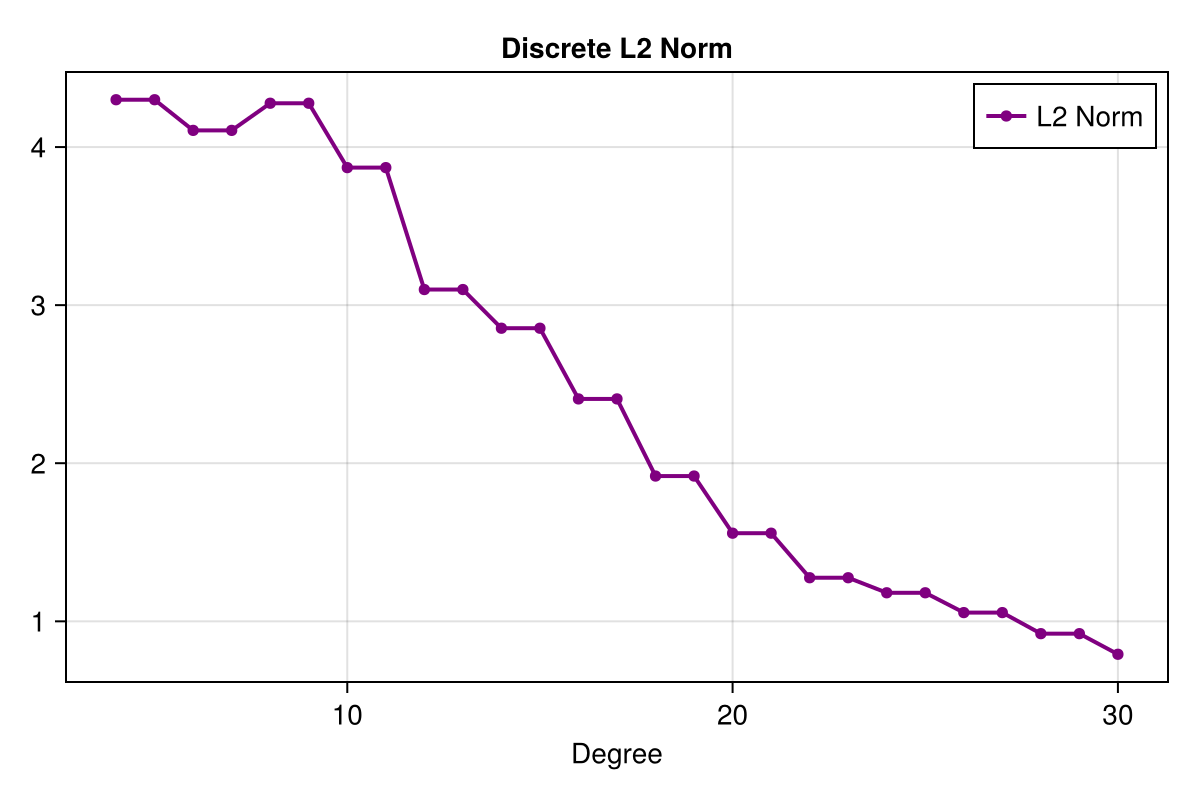

CairoMakie.Screen{IMAGE}


In [ ]:
fig_1 = plot_discrete_l2(results, d_min, d_max, 1)
# save("discrete_l2.pdf", fig_1)
display(fig_1)

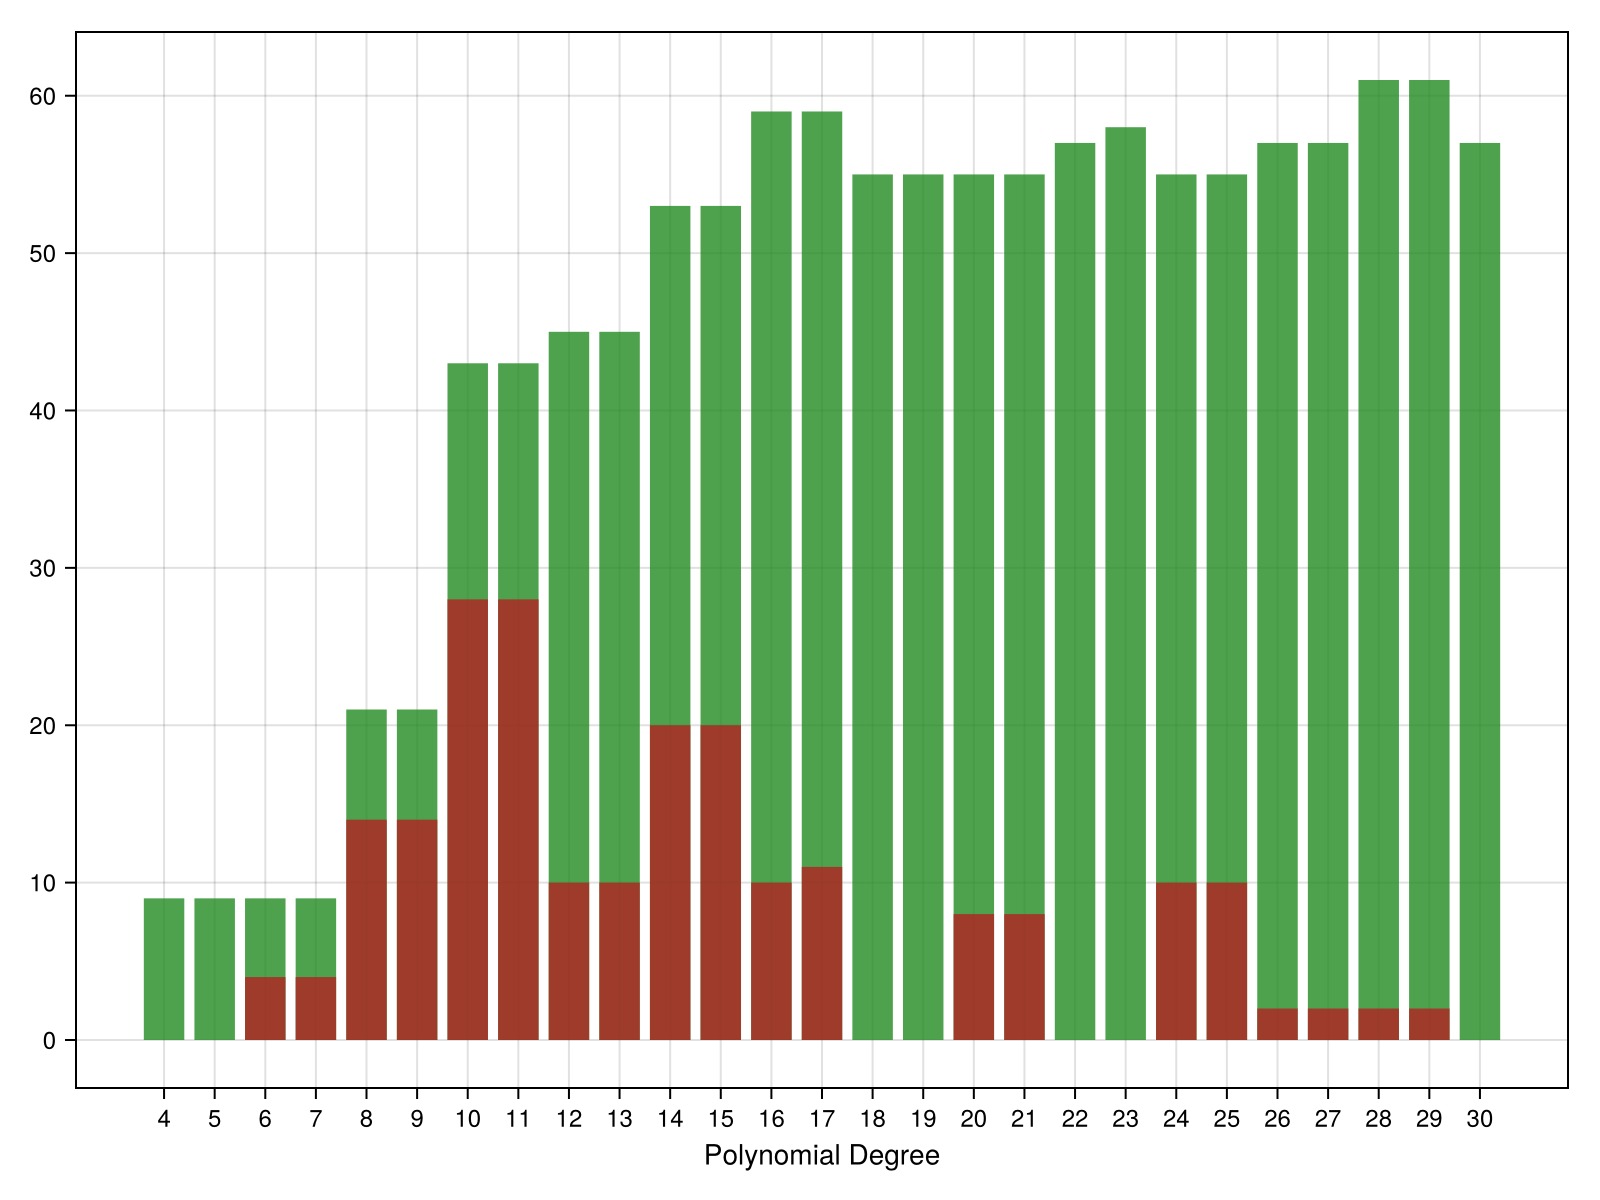

CairoMakie.Screen{IMAGE}


In [ ]:
fig_2 = capture_histogram(results, d_min, d_max, 1, tol_dist=TD, show_legend = false)
# save("histogram.pdf", fig_2)
display(fig_2)

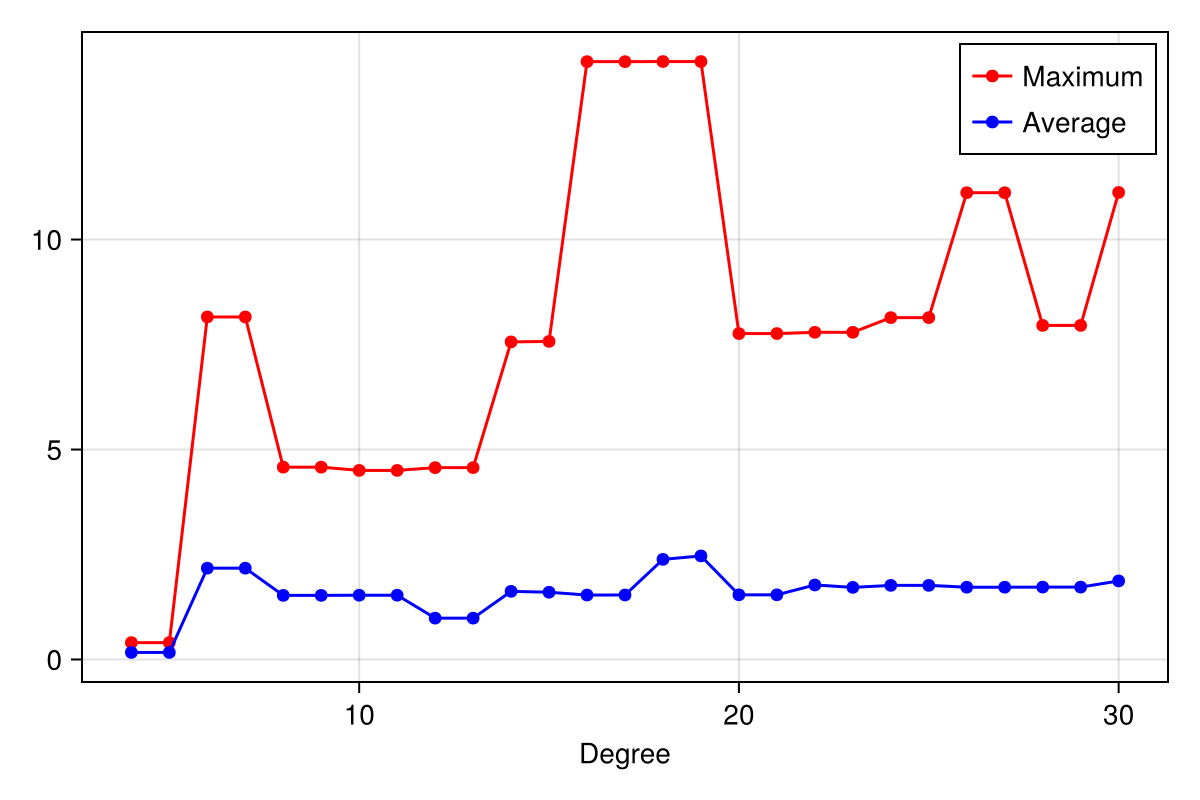

CairoMakie.Screen{IMAGE}


In [13]:
fig_3 = plot_convergence_analysis(results, d_min, d_max, 1)
# save("convergence_analysis.pdf", fig_3)
display(fig_3)

In [18]:
RT = results[18]
df_t = RT.df
df_m = RT.df_min;
# pol_cheb = Constructor(TR, 18, basis=:chebyshev)
sort!(df_t, :z)

Row,x1,x2,z,y1,y2,close,steps,converged
,Float64,Float64,Float64,Float64,Float64,Bool,Float64,Bool
1,8.11622,-9.86955,-18.7327,8.05502,-9.66459,true,5.0,true
2,-8.11622,-9.86955,-18.7327,-8.05502,-9.66459,true,5.0,true
3,-8.11622,9.86955,-18.7327,-8.05502,9.66459,true,5.0,true
4,8.11622,9.86955,-18.7327,8.05502,9.66459,true,5.0,true
5,-4.89775,9.88045,-10.8627,-4.85386,9.70211,true,5.0,true
6,4.89775,9.88045,-10.8627,4.85386,9.70211,true,5.0,true
7,4.89775,-9.88045,-10.8627,4.85386,-9.70211,true,5.0,true
8,-4.89775,-9.88045,-10.8627,-4.85386,-9.70211,true,5.0,true
9,8.05964,-6.51416,-9.49188,8.09758,-6.4795,true,4.0,true


Adding the mast here may not be that useful. We care of the minimal distance separating the optimized points from the critical points.

In [64]:
inside_mask = points_in_hypercube(df_t, TR)
values_mask = points_in_range(df_t, TR, 18.)
df_minimizers = df_t[values_mask .& inside_mask, :] # has both `x` (raw) and `y` (optimized)

Row,x1,x2,z,y1,y2,close,steps,converged
,Float64,Float64,Float64,Float64,Float64,Bool,Float64,Bool
1,8.11622,-9.86955,-18.7327,8.05502,-9.66459,true,5.0,true
2,-8.11622,-9.86955,-18.7327,-8.05502,-9.66459,true,5.0,true
3,-8.11622,9.86955,-18.7327,-8.05502,9.66459,true,5.0,true
4,8.11622,9.86955,-18.7327,8.05502,9.66459,true,5.0,true
5,-4.89775,9.88045,-10.8627,-4.85386,9.70211,true,5.0,true
6,4.89775,9.88045,-10.8627,4.85386,9.70211,true,5.0,true
7,4.89775,-9.88045,-10.8627,4.85386,-9.70211,true,5.0,true
8,-4.89775,-9.88045,-10.8627,-4.85386,-9.70211,true,5.0,true
9,8.05964,-6.51416,-9.49188,8.09758,-6.4795,true,4.0,true


In [101]:
CairoMakie.activate!
fig_1 = cairo_plot_polyapprox_levelset(pol_cheb, TR, df_t, df_m, show_captured=false)
# fig_1_p = cairo_plot_polyapprox_levelset(pol_cheb, TR, df_minimizers, df_m, show_captured=false)
# save("polyapprox_levelset_just_crit.pdf", fig_1)

CairoMakie.Screen{PDF}


In [92]:
stats = analyze_converged_points(df_t, TR, results, d_min, d_max, 1)

Dict{String, Any} with 10 entries:
  "overall_max"    => 8.8317
  "avg_distances"  => [2.93696, 2.93696, 3.62545, 3.62545, 1.69118, 1.69118, 0.…
  "n_converged"    => 120
  "degrees"        => [4, 5, 6, 7, 8, 9, 10, 11, 12, 13  …  21, 22, 23, 24, 25,…
  "min_distances"  => [1.64991e-14, 3.06612e-14, 4.08101e-14, 6.12774e-14, 1.00…
  "n_total_points" => 189
  "overall_avg"    => 0.886222
  "overall_min"    => 0.0
  "max_distances"  => [6.74779, 6.74779, 8.8317, 8.8317, 3.93948, 3.93948, 1.60…
  "n_valid"        => 120

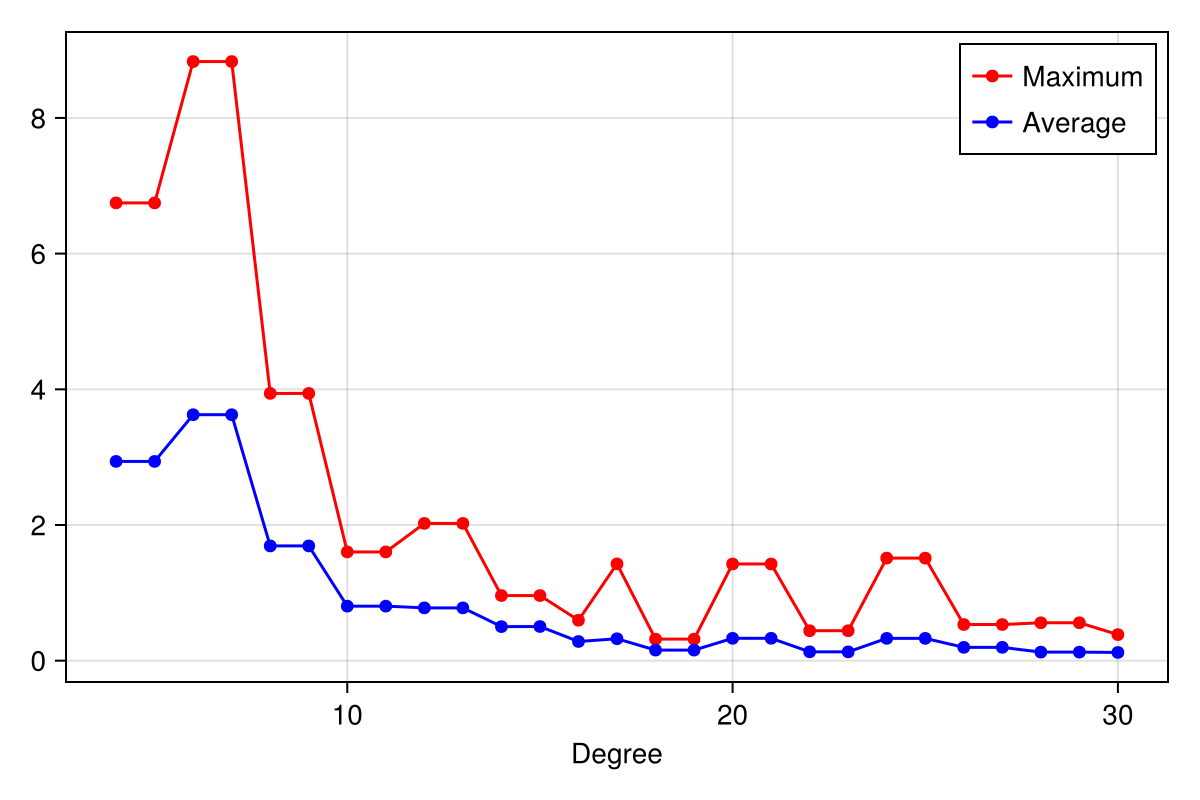

In [98]:
fig_5 = plot_distance_statistics(stats)
# save("distance_to_minimizer.pdf", fig_5)

In [94]:
function plot_distance_statistics(stats::Dict{String,Any}; show_legend::Bool=true)
    fig = Figure(size=(600, 400))

    ax = Axis(fig[1, 1],
        xlabel="Degree")

    # Plot maximum and average distances
    degrees = stats["degrees"]
    scatterlines!(ax, degrees, stats["max_distances"],
        label="Maximum",
        color=:red)
    scatterlines!(ax, degrees, stats["avg_distances"],
        label="Average",
        color=:blue)

    if show_legend
        axislegend(ax)
    end

    return fig
end

plot_distance_statistics (generic function with 1 method)

In [88]:
function analyze_converged_points(
    df_filtered::DataFrame,
    TR::test_input,
    results::Dict{Int,NamedTuple{(:df, :df_min, :convergence_stats, :discrete_l2),
        Tuple{DataFrame,DataFrame,NamedTuple,Float64}}},
    start_degree::Int,
    end_degree::Int,
    step::Int=1)

    degrees = start_degree:step:end_degree
    n_dims = count(col -> startswith(string(col), "x"), names(df_filtered))

    # Filter for converged points first
    df_converged = df_filtered[df_filtered.converged, :]

    # Filter for points where y is in domain and not NaN
    valid_points = trues(nrow(df_converged))
    for i in 1:nrow(df_converged)
        # Check if y coordinates are NaN
        y_coords = [df_converged[i, Symbol("y$j")] for j in 1:n_dims]
        if any(isnan.(y_coords))
            valid_points[i] = false
            continue
        end

        # Check if y coordinates are in domain
        for j in 1:n_dims
            if abs(df_converged[i, Symbol("y$j")] - TR.center[j]) > TR.sample_range
                valid_points[i] = false
                break
            end
        end
    end

    df_valid = df_converged[valid_points, :]
    n_valid_points = nrow(df_valid)

    # Initialize distance matrix
    point_distances = zeros(Float64, n_valid_points, length(degrees))

    # Calculate distances
    for (i, row) in enumerate(eachrow(df_valid))
        y_coords = [row[Symbol("y$j")] for j in 1:n_dims]

        for (d_idx, d) in enumerate(degrees)
            raw_points = results[d].df
            min_dist = Inf

            for raw_row in eachrow(raw_points)
                point = [raw_row[Symbol("x$j")] for j in 1:n_dims]
                dist = norm(y_coords - point)
                min_dist = min(min_dist, dist)
            end
            point_distances[i, d_idx] = min_dist
        end
    end

    # Calculate statistics
    stats = Dict{String,Any}()

    # Per-degree statistics
    stats["max_distances"] = [maximum(point_distances[:, i]) for i in 1:length(degrees)]
    stats["min_distances"] = [minimum(point_distances[:, i]) for i in 1:length(degrees)]
    stats["avg_distances"] = [mean(point_distances[:, i]) for i in 1:length(degrees)]

    # Overall statistics
    stats["overall_max"] = maximum(stats["max_distances"])
    stats["overall_min"] = minimum(stats["min_distances"])
    stats["overall_avg"] = mean(stats["avg_distances"])

    # Additional metadata
    stats["n_total_points"] = nrow(df_filtered)
    stats["n_converged"] = nrow(df_converged)
    stats["n_valid"] = n_valid_points
    stats["degrees"] = collect(degrees)

    return stats
end

analyze_converged_points (generic function with 2 methods)